In [1]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2531154894217202734
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7798259712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12815411811075000777
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:65:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
data_dir = pathlib.Path("D:/chip/datasets/chip_normal")

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

89303


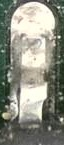

In [6]:
digit0 = list(data_dir.glob('1/*'))
PIL.Image.open(str(digit0[0]))

In [7]:
batch_size = 32
img_height = 128
img_width = 64

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 89303 files belonging to 4 classes.
Using 71443 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 89303 files belonging to 4 classes.
Using 17860 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['1', '2', '3', '4']


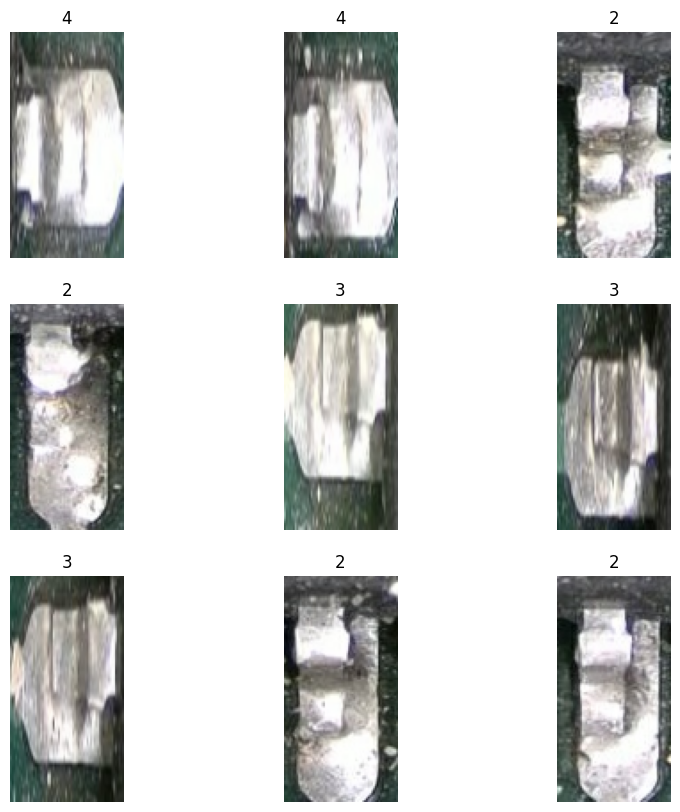

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 64, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)  # 미리 리스케일 값 점검

In [15]:
# 리스케일된 범위 확인
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.08144914 1.0


In [16]:
num_classes = len(class_names)

model = Sequential([
  # 특징 추출
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  # 학습
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 64, 3)        0         
                                                                 
 conv2d (Conv2D)             (None, 128, 64, 16)       448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 16, 64)        1

In [26]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
2233/2233 [==============================] - 17s 8ms/step - loss: 4.8050e-04 - accuracy: 1.0000 - val_loss: 2.7760e-05 - val_accuracy: 1.0000
Epoch 2/5
2233/2233 [==============================] - 15s 7ms/step - loss: 5.3474e-04 - accuracy: 1.0000 - val_loss: 3.3237e-05 - val_accuracy: 1.0000
Epoch 3/5
2233/2233 [==============================] - 15s 7ms/step - loss: 8.1641e-04 - accuracy: 0.9999 - val_loss: 5.3261e-06 - val_accuracy: 1.0000
Epoch 4/5
2233/2233 [==============================] - 16s 7ms/step - loss: 5.3367e-04 - accuracy: 1.0000 - val_loss: 1.0296e-05 - val_accuracy: 1.0000
Epoch 5/5
2233/2233 [==============================] - 16s 7ms/step - loss: 5.0364e-04 - accuracy: 1.0000 - val_loss: 3.2222e-08 - val_accuracy: 1.0000


In [27]:
model.save('result_recog_chip.h5') # 케라스 신경망 저장

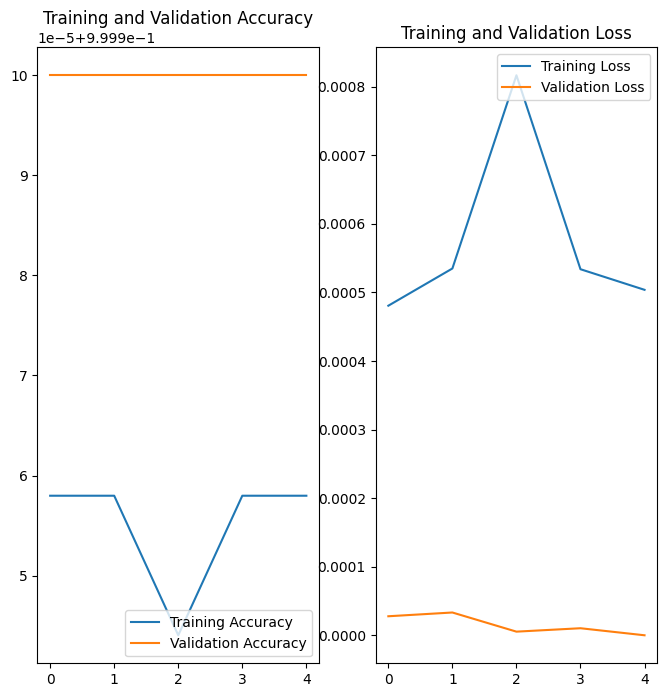

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
new_model = tf.keras.models.load_model('result_recog_chip.h5')

In [31]:
testimgpath = "D:/chip/testimg/crop_1850_4_202407091254.jpg"
img = tf.keras.utils.load_img(
    testimgpath, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = new_model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(score)
# print(class_names[np.argmax(score)])
print(np.argmax(score))


1/1 [==============================] - 0s 22ms/step
tf.Tensor([1.1408660e-20 1.9970755e-24 8.3653008e-11 1.0000000e+00], shape=(4,), dtype=float32)
3
